In [1]:
from collections import OrderedDict, defaultdict
import glob
import json
import os
from os.path import join, basename, abspath, exists
from os import makedirs

import cv2
from PIL import Image

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
valid = pd.read_csv('data/valid.csv')

In [3]:
train.head()

,Label,path
0,"{""single"": [{""geometry"": [{""x"": 1296, ""y"": 248...",data/images/P81228-095606.jpg
1,"{""single"": [{""geometry"": [{""x"": 393, ""y"": 1630...",data/images/IMG_20190306_171249.jpg
2,"{""single"": [{""geometry"": [{""x"": 2532, ""y"": 349...",data/images/P81230-092214.jpg
3,"{""single"": [{""geometry"": [{""x"": 592, ""y"": 1329...",data/images/P81221-130838.jpg
4,"{""single"": [{""geometry"": [{""x"": 2368, ""y"": 160...",data/images/IMG_20190313_133713.jpg


In [4]:
train.shape

(1780, 2)

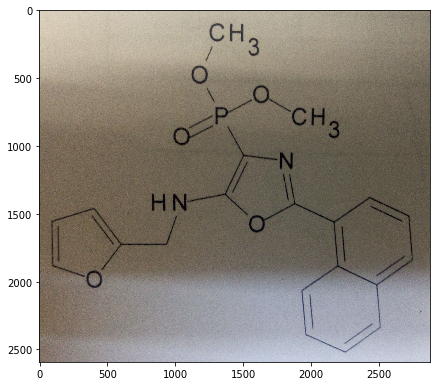

In [5]:
img_idx = 0
img_path = train.iloc[img_idx]['path']
img = cv2.imread(img_path)[..., ::-1]
plt.figure(figsize=(7, 7))
imshow(img);

In [6]:
from utils import parse_labelbox_config
from mol_labels_drawer import MolLabelsDrawer

In [7]:
draw_types, class_markers, class_colors = parse_labelbox_config('data/labelbox_config.json')

In [8]:
class_markers

{'single': 1,
 'double': 2,
 'triple': 3,
 'C_character': 4,
 'C_point': 5,
 'N': 6,
 'O': 7,
 'S': 8,
 'F': 9,
 'UP': 10,
 'Down': 11,
 'Ni': 12,
 'Cl': 13,
 'Br': 14,
 'NO2': 15,
 'Ge': 16,
 'P': 17,
 'Fe': 18,
 'Se': 19,
 'I': 20,
 'H': 21,
 'C_F_3': 22,
 'CN': 23,
 'B': 24,
 'OCH3': 25,
 'Si': 26,
 'Na': 27,
 'wedge': 28,
 'dash': 29}

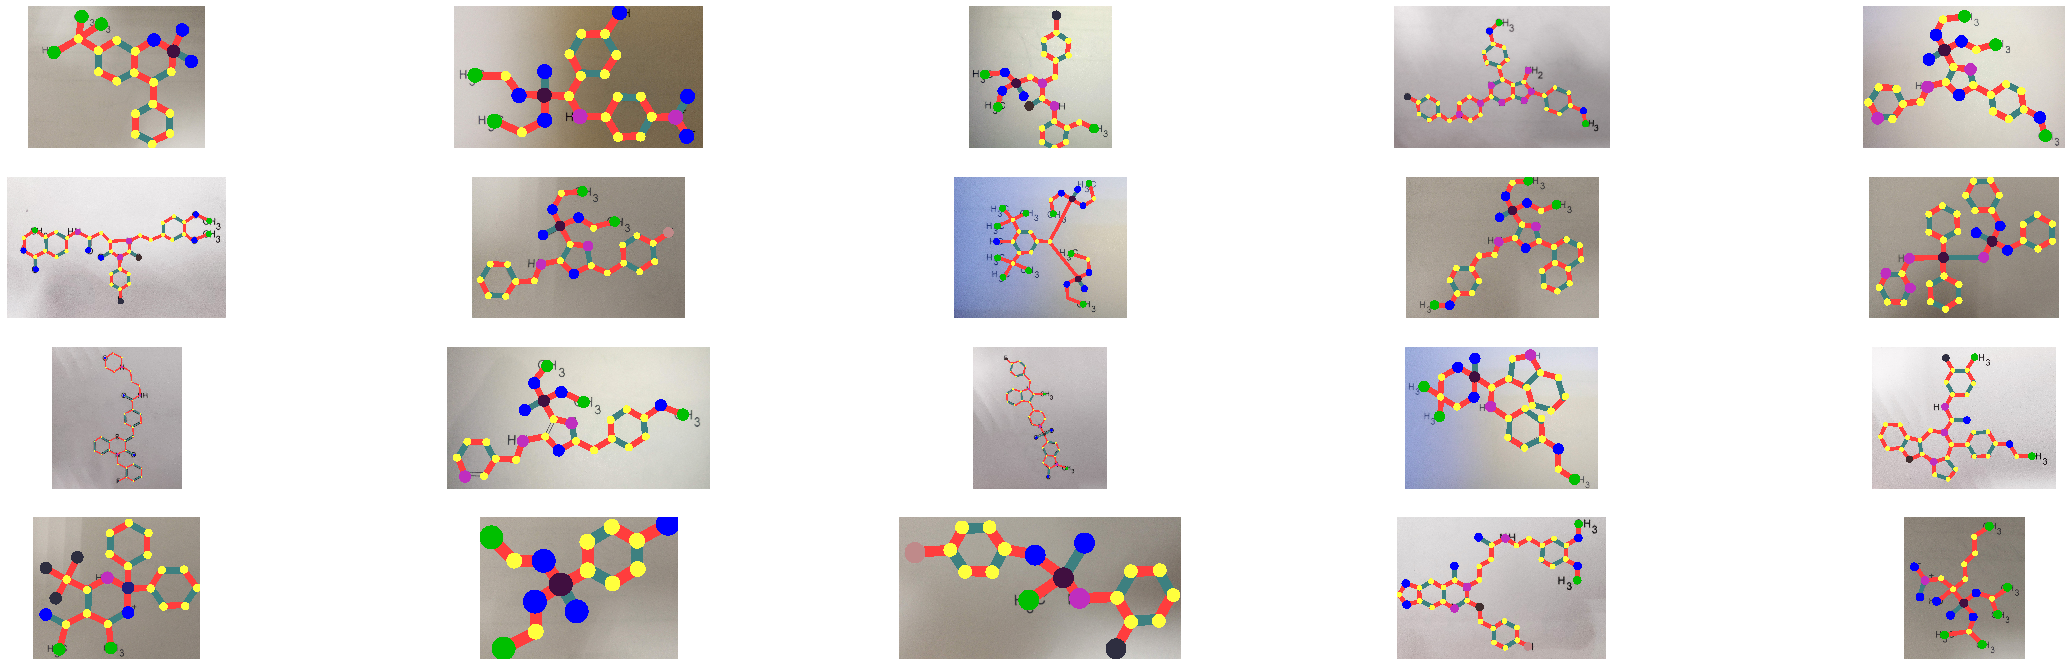

In [9]:
start = 1080
end = 1100

n_cols = 5
n_rows = np.ceil((end - start) / n_cols)
plt.figure(figsize=(n_cols * 8, n_rows * 3))

for img_idx in range(start, min(end, len(train))):
    json_label = train.iloc[img_idx]['Label']
    if json_label == 'Skip':
        continue
    img_labels = json.loads(json_label)
    if len(img_labels) == 0:
        continue
    
    img_path = train.iloc[img_idx]['path']
    img = cv2.imread(img_path)[..., ::-1]

    mol_drawer = MolLabelsDrawer(img, img_labels, draw_types, class_markers, class_colors, visualize=True)
    dst, mask = mol_drawer.draw_labels()

    plt.subplot(n_rows, n_cols, img_idx - start + 1)
    imshow(dst);
    plt.axis('off');

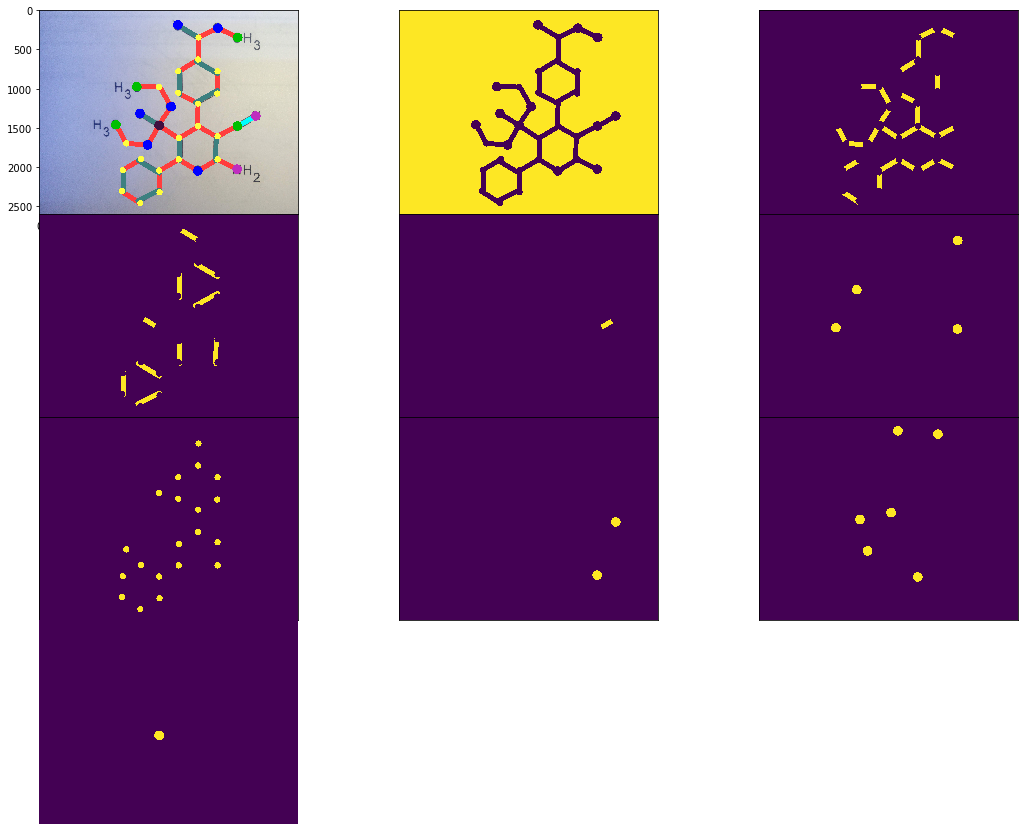

In [10]:
img_idx = 2

json_label = train.iloc[img_idx]['Label']
img_labels = json.loads(json_label)

img_path = train.iloc[img_idx]['path']
img = cv2.imread(img_path)[..., ::-1]

mol_drawer = MolLabelsDrawer(img, img_labels, draw_types, class_markers, class_colors, visualize=True)
dst, mask = mol_drawer.draw_labels()

unique_labels = np.unique(mask)
n = len(unique_labels)
num_cols = 3
num_rows = int(np.ceil((n + 1) / num_cols))
gs = gridspec.GridSpec(num_rows, num_cols, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.0)

plt.figure(figsize=(15, 11.3))
plt.axis('off');

ax = plt.subplot(gs[0])
ax.imshow(dst)
for i in range(min(num_rows*num_cols, n)):
    label_mask = (mask == unique_labels[i]).astype(np.uint8) * 255
    ax = plt.subplot(gs[i + 1])
    im = ax.imshow(label_mask)
    ax.set_xticks([])
    ax.set_yticks([])
ax.axis('off');

## Class weights

In [11]:
classes = {cl_name: idx for cl_name, idx in class_markers.items()}
rev_classes = {idx: cl_name for cl_name, idx in class_markers.items()}

In [12]:
counts = {cl_name: 0 for cl_name in class_markers.keys()}

In [13]:
for img_idx in range(0, len(train)):
    json_label = train.iloc[img_idx]['Label']
    
    if json_label == 'Skip':
        continue
    img_labels = json.loads(json_label)
    if len(img_labels) == 0:
        continue
    
    for cl_name in img_labels.keys():
        counts[cl_name] += 1

In [14]:
counts

{'single': 1701,
 'double': 1692,
 'triple': 40,
 'C_character': 1476,
 'C_point': 1700,
 'N': 1591,
 'O': 1631,
 'S': 473,
 'F': 463,
 'UP': 13,
 'Down': 10,
 'Ni': 1,
 'Cl': 457,
 'Br': 78,
 'NO2': 0,
 'Ge': 4,
 'P': 837,
 'Fe': 1,
 'Se': 4,
 'I': 6,
 'H': 19,
 'C_F_3': 0,
 'CN': 0,
 'B': 87,
 'OCH3': 0,
 'Si': 28,
 'Na': 0,
 'wedge': 0,
 'dash': 0}

In [15]:
max_count = max(counts.values())
weights = {}
for cl_name, count in counts.items():
    if count != 0:
        weights[cl_name] = max_count / count
    else:
        weights[cl_name] = max_count

In [16]:
weights

{'single': 1.0,
 'double': 1.0053191489361701,
 'triple': 42.525,
 'C_character': 1.1524390243902438,
 'C_point': 1.0005882352941176,
 'N': 1.0691389063482086,
 'O': 1.0429184549356223,
 'S': 3.5961945031712474,
 'F': 3.673866090712743,
 'UP': 130.84615384615384,
 'Down': 170.1,
 'Ni': 1701.0,
 'Cl': 3.7221006564551424,
 'Br': 21.807692307692307,
 'NO2': 1701,
 'Ge': 425.25,
 'P': 2.032258064516129,
 'Fe': 1701.0,
 'Se': 425.25,
 'I': 283.5,
 'H': 89.52631578947368,
 'C_F_3': 1701,
 'CN': 1701,
 'B': 19.551724137931036,
 'OCH3': 1701,
 'Si': 60.75,
 'Na': 1701,
 'wedge': 1701,
 'dash': 1701}

In [17]:
weights_ = np.zeros((len(weights) + 1,))
for cl_name, weight in weights.items():
    weights_[classes[cl_name]] = weight

In [18]:
# Add background weight
weights_[0] = 0.95

In [19]:
np.log(weights_ + 0.1)

array([0.04879016, 0.09531018, 0.10013412, 3.75244094, 0.22509287,
       0.0958448 , 0.1562675 , 0.13358504, 1.30730378, 1.32809996,
       4.8747862 , 5.13697422, 7.43903038, 1.34080018, 3.08683782,
       7.43903038, 6.05291236, 0.75718154, 7.43903038, 6.05291236,
       5.64756479, 4.49564898, 7.43903038, 7.43903038, 2.97816508,
       7.43903038, 4.10841182, 7.43903038, 7.43903038, 7.43903038])